**Model Selection Considerations**

| Data Assumptions | Assumptions Test |
|------|------|
|   Univariate Timeseries | N/A|
|   Normal Distribution | p-test, visual inspection of histograms, q-q plots, box plots |
|   Regular Time Series | domain knowledge/put a groupby on it|

- Like most forecasting problems, the uncertainty increases greatly as you predict further into the future. It is best to keep the forecast small. 
- Also auto-arima takes more time to run beacuse its cycles through every possible parameter combination to find the best ones. Another reason to keep the training set small. ~<1000 points takes ~1m to train on my machine
- Best practice includes training on a full seasonal cycle or at least not cutting data in between a season. 

**Use Cases**
- Good for really any type of time series data.

**Dependencies**

In [165]:
import pandas as pd
import matplotlib.pyplot as plt 

In [166]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pmdarima as pm
from pmdarima.arima import auto_arima
from pmdarima import model_selection
from pmdarima.pipeline import Pipeline

**Load Data**

In [43]:
df = pd.read_csv('data/example_wp_log_peyton_manning.csv')
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


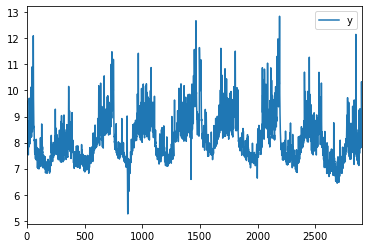

In [44]:
df.plot()

In [45]:
#split dataset into smaller dataset for forecasting
df = df[:(int(len(df)*.2))]
df.tail()

,ds,y
576,2009-08-06,8.172164
577,2009-08-07,7.811568
578,2009-08-08,7.575072
579,2009-08-09,7.658700
580,2009-08-10,7.866339


# **Data Preperation: Required Inputs and Format**
- Dataframe with one column of dependent values
- (Required) y : array-like or iterable, shape=(n_samples,)
            The time-series to which to fit the ``ARIMA`` estimator. This may
            either be a Pandas ``Series`` object (statsmodels can internally
            use the dates in the index), or a numpy array. This should be a
            one-dimensional array of floats, and should not contain any
            ``np.nan`` or ``np.inf`` values. 
- Don't train on an incomplete cycle preferably 

In [46]:
#preprocessing (since arima takes univariate series as input)
df.drop('ds',axis=1,inplace=True)
print('len dataset:' + str(len(df)))
df.head()

len dataset:581


/Users/anaisdotis-georgiou/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,y
0,9.590761
1,8.519590
2,8.183677
3,8.072467
4,7.893572


In [47]:
#conver data into array although the dataframe works as well 
data = df.values

In [51]:
#divide into train and validation set
ts=450
train, test = model_selection.train_test_split(data, train_size=ts)

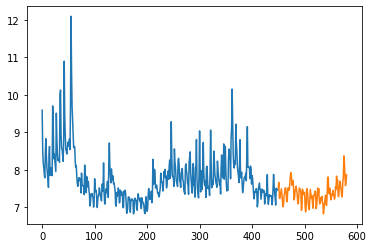

In [52]:
#plotting the data for vis purposes
x_data = range(len(data))
plt.plot(x_data[:ts], train[:])
plt.plot(x_data[ts:], test[:])

**Optional Inputs**
- exogenous : array-like, shape=[n_obs, n_vars], optional (default=None)
            An optional 2-d array of exogenous variables. If provided, these
            variables are used as additional features in the regression
            operation. This should not include a constant or trend. Note that
            if an ``ARIMA`` is fit on exogenous features, it must be provided
            exogenous features for making predictions.
- exogenous definition: An independent variable that affects a model without being affected by it, and whose qualitative characteristics and method of generation are not specified by the model builder. I.E. if you wanted to model the temperature of a soup in a pot, the preprogrammed temperature of the hot plate would be the exogenous variable. 
- Tons of optional arguments listed [here](https://github.com/alkaline-ml/pmdarima/blob/b79db3111e087e6a6a2181de1f267fcd2d953079/pmdarima/arima/auto.py#L69) (source) and [here](https://pkg.robjhyndman.com/forecast/reference/auto.arima.html) (documentation). However, auto-arima should be able to find all of those parameters for you, so you don't have to explicitly define them. 
- My recommendation is to just include the following as optional arguments:

`(m=1, seasonal=True, stationary=False, trace=True, error_action='ignore', suppress_warnings=True)`
- With advance options to change the rest of the parameters (defaults inclueded):

`(exogeneous=None, start_p=2, d=None, start_q=2, max_p=5, max_d=2, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2,max_order=10, information_criterion='aic',alpha=0.05,test='kpss',seasonal_test='ch',stepwise=True, n_jobs=1, start_params=None, transparams=True,method=None, trend='c', solver=None, maxiter=50, out_of_sample_size=0, scoring='mse')`

**Input Defaults**
- just a the dependent variable

# **Minimal Output**
- Plain forecast without exogeneous series

In [53]:
# Fit a simple auto_arima model
from pmdarima.arima import auto_arima
model = pm.auto_arima(train, seasonal=True, stationary=False,
                     stepwise=True, suppress_warnings=True, m=12,
                     error_action='ignore')

Test RMSE: 0.296


Text(0.5, 0, 'Counter')

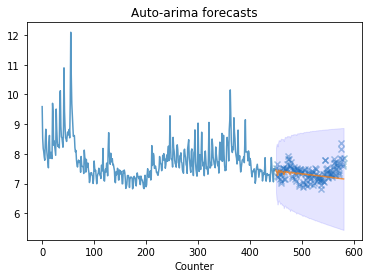

In [55]:
preds, conf_int = model.predict(n_periods=test.shape[0], return_conf_int=True)
# Print the error:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds)))

# #############################################################################
# Plot the points and the forecasts
x_axis = np.arange(train.shape[0] + preds.shape[0])

plt.plot(x_axis[:train.shape[0]], train, alpha=0.75)
plt.plot(x_axis[train.shape[0]:], preds, alpha=0.75)  # Forecasts
plt.scatter(x_axis[train.shape[0]:], test,
            alpha=0.4, marker='x')  # Test data
plt.fill_between(x_axis[-preds.shape[0]:],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b')
plt.title("Auto-arima forecasts")
plt.xlabel("Counter")

In [59]:
#What a plain forecast output would look like without appending to validation set. The actual output we would get assuming evaluation would happen in a seperate image. 
forecast = model.predict(n_periods=(len(test)))
forecast = pd.DataFrame(forecast, columns=['Prediction'])
forecast.tail()


,Prediction
126,7.162686
127,7.160198
128,7.157393
129,7.155969
130,7.153794


# **Model Considerations**
- taking a look at the distribution of our data, normalizing it, and applying a new fit

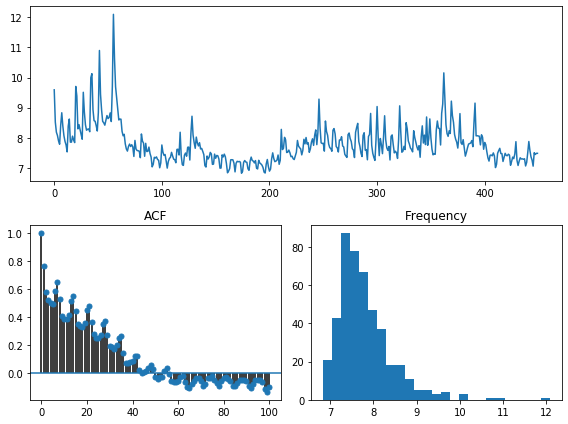

In [110]:
from pmdarima.utils import tsdisplay
tsdisplay(train, lag_max=100)

In [65]:
fit1 = pm.auto_arima(train, m=12, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(1, 0, 1, 12) (constant=True); AIC=431.511, BIC=464.368, Time=1.226 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 12) (constant=True); AIC=529.603, BIC=537.817, Time=0.047 seconds
Fit ARIMA: (1, 1, 0)x(1, 0, 0, 12) (constant=True); AIC=521.399, BIC=537.827, Time=0.151 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 1, 12) (constant=True); AIC=513.767, BIC=530.195, Time=0.263 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 12) (constant=False); AIC=527.655, BIC=531.762, Time=0.013 seconds
Fit ARIMA: (2, 1, 2)x(0, 0, 1, 12) (constant=True); AIC=431.573, BIC=460.323, Time=1.116 seconds
Fit ARIMA: (2, 1, 2)x(1, 0, 0, 12) (constant=True); AIC=432.607, BIC=461.357, Time=1.292 seconds
Fit ARIMA: (2, 1, 2)x(2, 0, 1, 12) (constant=True); AIC=431.869, BIC=468.832, Time=4.499 seconds
Fit ARIMA: (2, 1, 2)x(1, 0, 2, 12) (constant=True); AIC=432.074, BIC=469.038, Time=4.758 seconds
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 12) (constant=True); AIC=439.946, BIC=464.588, Time=

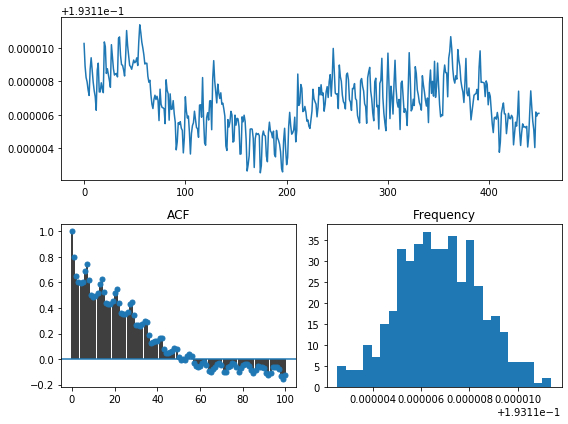

In [116]:
from pmdarima.preprocessing import BoxCoxEndogTransformer

train_bc, _ = BoxCoxEndogTransformer().fit_transform(train)
tsdisplay(train_bc, lag_max=100)

In [113]:
from pmdarima.pipeline import Pipeline

fit2 = Pipeline([
    ('boxcox', BoxCoxEndogTransformer()),
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           m=12,
                           error_action="ignore"))
])

fit2.fit(train)

Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(1, 0, 1, 12) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 12) (constant=True); AIC=nan, BIC=nan, Time=0.073 seconds
Fit ARIMA: (1, 1, 0)x(1, 0, 0, 12) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 1, 12) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 12) (constant=False); AIC=nan, BIC=nan, Time=0.055 seconds
Fit ARIMA: (0, 1, 0)x(1, 0, 0, 12) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 1, 12) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (0, 1, 0)x(1, 0, 1, 12) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 12) (constant=True); AIC=nan, BIC=nan, Time=0.101 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 12) (constant=True); AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 12) (constant=True); AIC=nan, BIC=nan, Time=0.138

Pipeline(steps=[('boxcox',
                 BoxCoxEndogTransformer(floor=1e-16, lmbda=None, lmbda2=0,
                                        neg_action='raise')),
                ('arima',
                 AutoARIMA(D=None, alpha=0.05, d=None, error_action='ignore',
                           information_criterion='aic', m=12, max_D=1, max_P=2,
                           max_Q=2, max_d=2, max_order=5, max_p=5, max_q=5,
                           maxiter=50, method='lbfgs', n_fits=10, n_jobs=1,
                           offset_test_args=None, out_of_sample_size=0,
                           random=False, random_state=None, scoring='mse',
                           scoring_args=None, seasonal=True,
                           seasonal_test='ocsb', seasonal_test_args=None,
                           start_P=1, start_Q=1, start_p=2, start_params=None, ...))])

Test RMSE: 0.285


Text(0.5, 0, 'Counter')

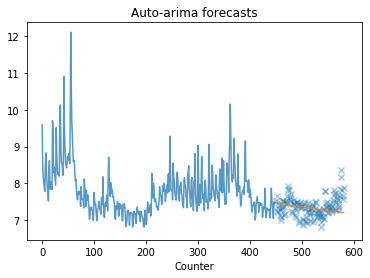

In [120]:
preds = fit2.predict(n_periods=test.shape[0])
# Print the error:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds)))

# #############################################################################
# Plot the points and the forecasts
x_axis = np.arange(train.shape[0] + preds.shape[0])

plt.plot(x_axis[:train.shape[0]], train, alpha=0.75)
plt.plot(x_axis[train.shape[0]:], preds, alpha=0.75)  # Forecasts
plt.scatter(x_axis[train.shape[0]:], test,
            alpha=0.4, marker='x')  # Test data
plt.title("Auto-arima forecasts")
plt.xlabel("Counter")

**Notice how the RMSE is lower** 
- this is not an excellent example of the benefit of boxcox transformation because the part of the data that we're performing the forecast onto matches the skew. However I still believe that offering the ability to apply a boxcox transformation would be useful and at the very least shiny

In [127]:
# example of prediction output--notice how the values have shifted to the right
bc_forecast = pd.DataFrame(preds, columns=['Prediction'])
bc_forecast.head()

,Prediction
0,7.479793
1,7.477471
2,7.475154
3,7.472841
4,7.470532


# **Example of ARIMAX: Addition of exogenous series**

In [167]:
import pmdarima as pm
from pmdarima.arima import auto_arima
from pmdarima import model_selection
from pmdarima.pipeline import Pipeline
from pmdarima.datasets import load_msft

In [168]:
msft = load_msft()
print(f"len:{len(msft)}")
msft.head()

len:7983


,Date,Open,High,Low,Close,Volume,OpenInt
0,1986-03-13,0.06720,0.07533,0.06720,0.07533,1371330506,0
1,1986-03-14,0.07533,0.07533,0.07533,0.07533,409569463,0
2,1986-03-17,0.07533,0.07533,0.07533,0.07533,176995245,0
3,1986-03-18,0.07533,0.07533,0.07533,0.07533,90067008,0
4,1986-03-19,0.07533,0.07533,0.07533,0.07533,63655515,0


In [169]:
data = msft.values
data[0,1:5]

array([0.0672, 0.07533, 0.0672, 0.07533], dtype=object)

In [201]:
#with dataframe
train, test = model_selection.train_test_split(msft, train_size=7000)

In [170]:
#with nparray
train, test = model_selection.train_test_split(data, train_size=7000)

In [161]:
train[:,1:5]

array([[0.0672, 0.07533, 0.0672, 0.07533],
       [0.07533, 0.07533, 0.07533, 0.07533],
       [0.07533, 0.07533, 0.07533, 0.07533],
       ...,
       [33.925, 33.952, 33.2, 33.265],
       [33.255, 33.546, 33.128, 33.437],
       [33.501, 33.646, 32.939, 33.11]], dtype=object)

<a id='exogenous_training'></a> **Exogenous Training**

In [ ]:
#with dataframe
exo_model = pm.auto_arima(train['Open'], trace=True, suppress_warnings=True,exogenous=train[['High','Low','Close']], stationarity=False, seasonality=True)

In [172]:
#with np.array 
exo_model = pm.auto_arima(train[:,1], trace=True, suppress_warnings=True,exogenous=train[:,2:5], stationarity=False, seasonality=True)

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=-6861.068, BIC=-6799.385, Time=9.789 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=-6851.046, BIC=-6816.777, Time=2.204 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=-6862.744, BIC=-6821.622, Time=1.784 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-6862.205, BIC=-6821.083, Time=1.272 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=-6853.012, BIC=-6825.597, Time=2.744 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=-6863.242, BIC=-6815.266, Time=6.561 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=-6861.899, BIC=-6807.069, Time=6.663 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-6861.353, BIC=-6806.524, Time=2.956 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-6862.635, BIC=-6814.659, Time=5.314 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-

In [173]:
exo_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7000
Model:               SARIMAX(2, 0, 0)   Log Likelihood                3438.621
Date:                Wed, 18 Mar 2020   AIC                          -6863.242
Time:                        12:26:00   BIC                          -6815.266
Sample:                             0   HQIC                         -6846.710
                               - 7000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0004      0.007     -0.064      0.949      -0.014       0.013
x1             0.7791      0.003    269.796      0.000       0.773       0.785
x2             0.7761      0.003    260.871      0.000       0.770       0.782
x3            -0.5553      0.004   -132.745      0.000      -0.564      -0.547
ar.L1          0.0434      0.007      6.493      0.000       0.030       0.057
ar.L2          0.0187      0.007      2.690      0.007       0.005       0.032
sigma2         0.0219      0.000    167.045      0.000       0.022       0.022
===================================================================================
Ljung-Box (Q):                      149.48   Jarque-Bera (JB):            231920.50
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             176.08   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [191]:
train

array([['1986-03-13', 0.0672, 0.07533, ..., 0.07533, 1371330506, 0],
       ['1986-03-14', 0.07533, 0.07533, ..., 0.07533, 409569463, 0],
       ['1986-03-17', 0.07533, 0.07533, ..., 0.07533, 176995245, 0],
       ...,
       ['2013-12-13', 33.925, 33.952, ..., 33.265, 44200101, 0],
       ['2013-12-16', 33.255, 33.546, ..., 33.437, 35002374, 0],
       ['2013-12-17', 33.501, 33.646, ..., 33.11, 50273973, 0]],
      dtype=object)

<a id='another_cell'></a>

Test RMSE: 0.274


Text(0.5, 0, 'Counter')

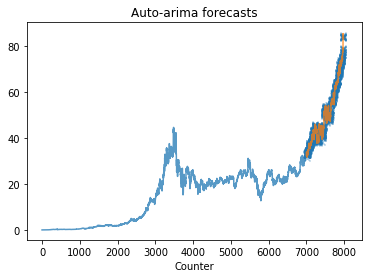

In [195]:
preds = exo_model.predict(n_periods=test.shape[0],exogenous=test[:,2:5])
# Print the error:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test[:,1], preds)))

# #############################################################################
# Plot the points and the forecasts
x_axis = np.arange(train[:,1].shape[0] + preds.shape[0])

plt.plot(x_axis[:train[:,1].shape[0]], train[:,1], alpha=0.75)
plt.plot(x_axis[train[:,1].shape[0]:], preds, alpha=0.75)  # Forecasts
plt.scatter(x_axis[train[:,1].shape[0]:], test[:,1],
            alpha=0.4, marker='x')  # Test data
plt.title("Auto-arima forecasts")
plt.xlabel("Counter")

<a id='exogenous_prediction_output'></a> **Exogenous Prediction Output**

In [199]:
#with dataframe
preds = exo_model.predict(n_periods=test.shape[0],exogenous=test[['High','Low','Close']])
#with np.array
preds = exo_model.predict(n_periods=test.shape[0],exogenous=test[:,2:5])
preds

array([32.43880843, 32.95249399, 33.02195703, 33.3355207 , 33.36485942,
       33.78337084, 33.94815607, 33.58974399, 33.89627705, 33.8113185 ,
       33.45960832, 33.27238599, 32.91760193, 32.5557041 , 32.38155647,
       32.54084336, 32.3371281 , 31.69542927, 32.70279193, 33.10912977,
       33.13352497, 33.16649999, 32.71824213, 32.35539785, 33.69341421,
       33.2310105 , 32.59383349, 32.8505818 , 32.9823323 , 33.43352174,
       34.0983481 , 33.47078104, 32.91375848, 32.49951953, 32.77482915,
       32.9981333 , 33.53741674, 33.93518934, 34.0723629 , 34.01049351,
       34.42127942, 34.21346459, 34.3125818 , 34.86180236, 34.51202289,
       34.36792624, 34.21169985, 34.1510003 , 34.74539476, 34.54641815,
       34.88526851, 34.78985182, 34.72088337, 34.78906218, 34.60259124,
       34.65833429, 34.72184322, 34.82380481, 34.6005926 , 34.82077761,
       35.42370252, 35.80549965, 36.28214767, 37.12458959, 36.63042389,
       37.03509071, 36.85721944, 36.36611434, 36.60043398, 37.37

# **UI and UX Proposal**

*Please note I am NOT a designer, but I hope this illustrates my proposed path better*
[Another Cell](#another_cell)
